# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Основные шаги:
* Загрузка и изучение данных
* Предобработка данных
* Подготовка выборки для обучения моделей.
* Обучение моделей
* Анализ моделей
* Вывод

# Описание данных
**Признаки**
* `DateCrawled` — дата скачивания анкеты из базы
* `VehicleType` — тип автомобильного кузова
* `RegistrationYear` — год регистрации автомобиля
* `Gearbox` — тип коробки передач
* `Power` — мощность (л. с.)
* `Model` — модель автомобиля
* `Kilometer` — пробег (км)
* `RegistrationMonth` — месяц регистрации автомобиля
* `FuelType` — тип топлива
* `Brand` — марка автомобиля
* `Repaired` — была машина в ремонте или нет
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя

Целевой признак
* `Price` — цена (евро)

In [2]:
%%capture
%pip install ydata-profiling;

In [3]:
%%capture

%pip install sweetviz

In [123]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import make_column_transformer
from tqdm import tqdm
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from ydata_profiling import ProfileReport
import sweetviz as sv
from sklearn.dummy import DummyRegressor

## Подготовка данных

In [56]:
df = pd.read_csv('/datasets/autos.csv')

In [57]:
# напишем функцию, которая облегчит получение общей информации о файле
def brief_df (df):
  # Подсчитываем пустые и уникальные значение
  rows_na =df.isna().sum().reset_index().rename(columns={0: "values_na"})
  rows_notna = df.notna().sum().reset_index().rename(columns={0: "values_not_na"})
  rows_analysis = pd.merge(rows_na, rows_notna, on="index", how= "outer")
  rows_analysis["complete_ratio"] = round((rows_analysis["values_not_na"]) / 
                                         len(df)*100,2)

  cardinality = df.nunique().reset_index().rename(columns={0: "cardinality"})
  rows_analysis = pd.merge(rows_analysis, cardinality)

  # Размер датасета и кол-во дубликатов
  print("Размер:", df.shape)
  dup_raw = df.duplicated().sum()
  dup_per = round((dup_raw*100)/df.shape[0],4)
  print ("Дубликаты:", dup_raw, "--->", dup_per, "%")

  # Статистика по пустым значениям
  print("Проверка на отсутсвующие значениия")
  display(rows_analysis)

  # Первые пять строк
  print("Первые пять строк")
  display(df.head())

In [60]:
df[(df['RegistrationYear'] > 2016) | (df['RegistrationYear'] >= 2023)]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23 00:00:00,0,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10 00:00:00,0,31139,2016-03-16 09:16:46
48,2016-03-25 14:40:12,7750,NaN,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN,2016-03-25 00:00:00,0,48499,2016-03-31 21:47:44
51,2016-03-07 18:57:08,2000,NaN,2017,manual,90,punto,150000,11,gasoline,fiat,yes,2016-03-07 00:00:00,0,66115,2016-03-07 18:57:08
57,2016-03-10 20:53:19,2399,NaN,2018,manual,64,other,125000,3,NaN,seat,no,2016-03-10 00:00:00,0,33397,2016-03-25 10:17:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354112,2016-03-11 15:49:51,3600,NaN,2017,manual,86,transit,150000,5,gasoline,ford,NaN,2016-03-11 00:00:00,0,32339,2016-03-12 05:45:02
354140,2016-03-29 16:47:29,1000,NaN,2017,manual,101,a4,150000,9,NaN,audi,NaN,2016-03-29 00:00:00,0,38315,2016-04-06 02:44:27
354203,2016-03-17 00:56:26,2140,NaN,2018,manual,80,fiesta,150000,6,NaN,ford,no,2016-03-17 00:00:00,0,44866,2016-03-29 15:45:04
354253,2016-03-25 09:37:59,1250,NaN,2018,NaN,0,corsa,150000,0,petrol,opel,NaN,2016-03-25 00:00:00,0,45527,2016-04-06 07:46:13


In [63]:
brief_df(df)

Размер: (354369, 16)
Дубликаты: 4 ---> 0.0011 %
Проверка на отсутсвующие значениия


,index,values_na,values_not_na,complete_ratio,cardinality
0,DateCrawled,0,354369,100.00,271174
1,Price,0,354369,100.00,3731
2,VehicleType,37490,316879,89.42,8
3,RegistrationYear,0,354369,100.00,151
4,Gearbox,19833,334536,94.40,2
5,Power,0,354369,100.00,712
6,Model,19705,334664,94.44,250
7,Kilometer,0,354369,100.00,13
8,RegistrationMonth,0,354369,100.00,13
9,FuelType,32895,321474,90.72,7


Первые пять строк


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [64]:
# выведем краткую описательную статистику
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


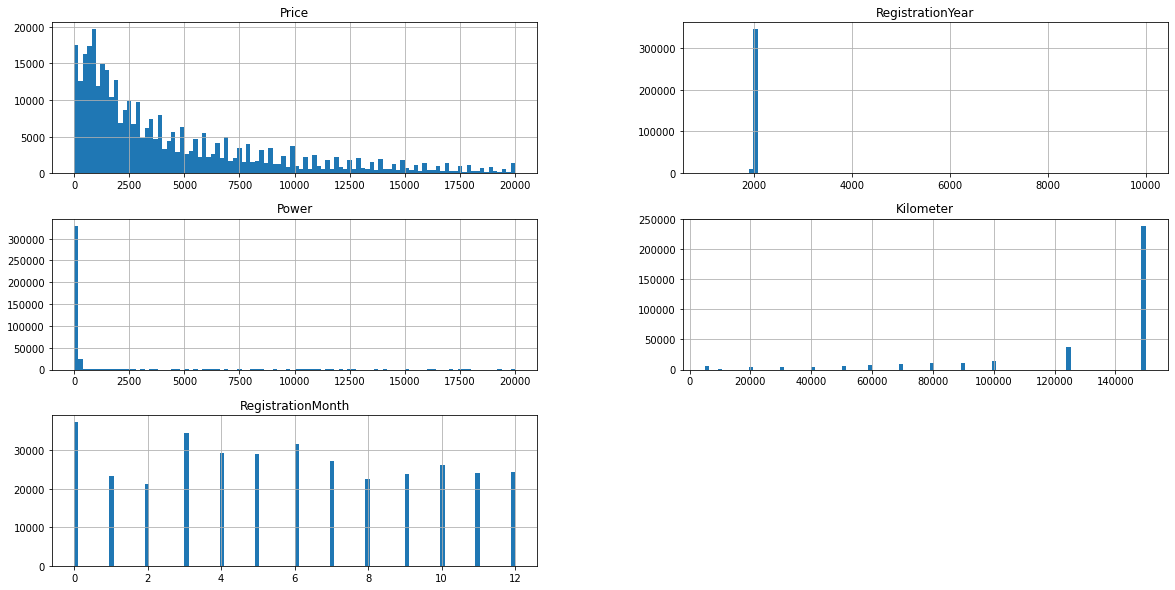

In [65]:
# посмотрим, как распределяются данные в признаках
df[['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']].hist(bins=100, figsize=(20,10));

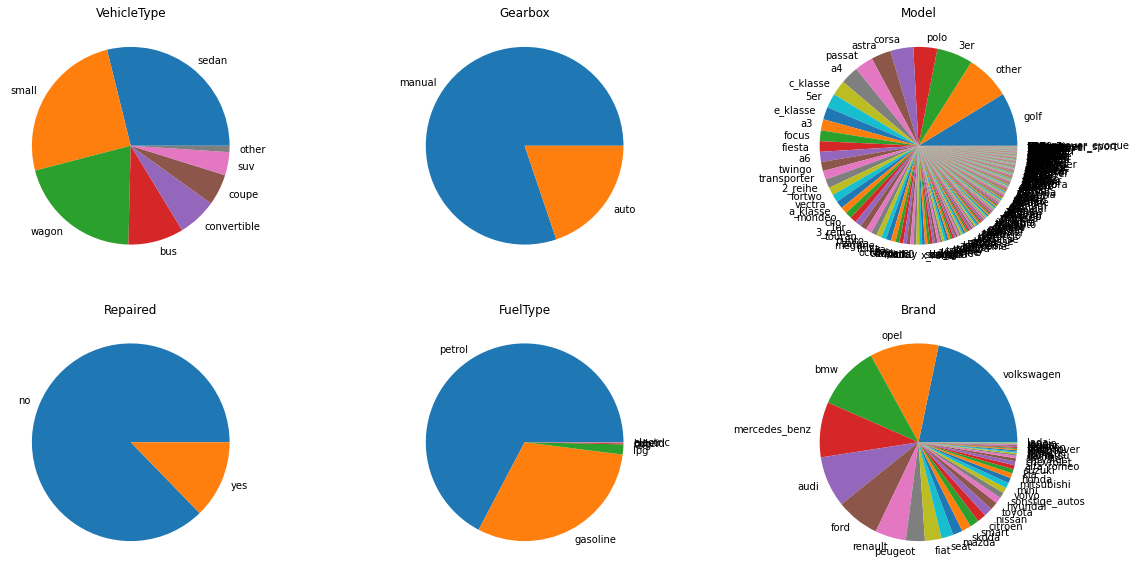

In [66]:
# посмотрим распределение в категориальных признаках
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

# построим каждую круговую диаграмму на отдельном участке
axs[0, 0].pie(df['VehicleType'].value_counts(), labels = df['VehicleType'].value_counts().index.tolist())
axs[0, 0].set_title('VehicleType')
axs[0, 1].pie(df['Gearbox'].value_counts(), labels = df['Gearbox'].value_counts().index.tolist())
axs[0, 1].set_title('Gearbox')
axs[0, 2].pie(df['Model'].value_counts(), labels = df['Model'].value_counts().index.tolist())
axs[0, 2].set_title('Model')
axs[1, 0].pie(df['Repaired'].value_counts(), labels = df['Repaired'].value_counts().index.tolist())
axs[1, 0].set_title('Repaired')
axs[1, 1].pie(df['FuelType'].value_counts(), labels = df['FuelType'].value_counts().index.tolist())
axs[1, 1].set_title('FuelType')
axs[1, 2].pie(df['Brand'].value_counts(), labels = df['Brand'].value_counts().index.tolist())
axs[1, 2].set_title('Brand')

plt.show()

In [67]:
# посмотрим, есть ли неявные дубликаты
df['Brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

In [68]:
# записей с годом регистрации автомобиля до 1937 и после 2023
len(df[(df['RegistrationYear'] < 1937) | (df['RegistrationYear'] > 2023)])

308

In [69]:
# записей с авто, мощнее 300л.с.
len(df[df['Power'] > 300])

3505

In [70]:
# записей с нулевой ценой
len(df[df['Price'] == 0])/len(df)*100

3.0397692800442475

**Резюме**

1. 4 явных дубликата удаляем;
2. В данных достаточно большой объем пропусков;
3. в `cardinality` видим, что столбец *NumberOfPictures* содержит только одно значение, и значит в обучении не поможет, как и *DateCrawled*, *DateCreated*, *PostalCode*, *LastSeen* (вероятно, *RegistrationMonth* так же не поможет, но удалить успеем после первчиного анализа);
4. ???к столбцам с категориальными данными стоит применить прямое/порядковое кодирование???;
5. стоит привести названия столбцов к змеиному регистру;

Отдельно отметим "аномалии":
1. неявные дубликаты в *FuelType*: petrol то же самое что и gasoline;
2. *Price*: около 10% смешных цен менее 10€ – рыночек порешал;
3. в *RegistrationYear* около 200 записей больше текущего года и меньше 1937 их стоит удалить как неиноформативные;
4. *Power*: 3505 (чуть меньше 1%) моделей оказалась мощнее 300л.с. Вероятно, данные были записаны с *десятыми и сотыми долями*, после чего разделитель потерялся, а мы получили реактивый опель. Также есть значения равные 0, если с прицепами всё понятно, то остальные, видимо, тотал их пока оставим;
5. (x) *Kilometer* авто с пробегом 150тыс. заметно больше остальных, но ничего криминального;
Также в столбцах *Power*, *RegistrationMonth* **0** стоит воспринимать как заглушку.

Отдельно по пропускам:
1. *VehicleType*, *Repaired*, *Gearbox*  закроем заглушкой;
2. *Model* здравый смысл подсказывает, что это один из самых значимых признаков, и его отсутствие делает неинформативным всю строку. Удаляем;
3. *FuelType* заполним самым частым – `petrol`;
4. в *Brand* есть бренд прицепов `sonstige_autos`, пропуски в котором стоит обработать отдельно;

Итого, данные выглядят довольно грязными. Чтобы не потерять часть данных и не запутаться в их обработке, порядок предобработки будет следующим:
1. удаление неинформативных столбцов
2. приведение к регистру
3. удаление явных дубликатов
4. обработка неявных дубликатов
5. обработка пропусков: сперва прицепы, затем *model*, затем *fuel_type*, заглушка `other` для трех столбцов
6. *registration_year*
7. *power*

## Предобработка данных

In [71]:
# удаляем неинформативные столбцы
df = df.drop(['NumberOfPictures', 'DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen'], axis=1)
df.shape

(354369, 11)

In [72]:
# приводим названия колонок к нижнему и змеиному_регистру
df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
df.columns


/tmp/ipykernel_200/3622208049.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]


Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired'],
      dtype='object')

In [73]:
# на этом шаге выясняется, что 4 дубликата превратились в 7.8% от всего массива
round(df.duplicated().sum()/len(df)*100, 2)

7.77

In [74]:
# удаляем дубликаты
df = df.drop_duplicates()
df.shape

(326826, 11)

In [75]:
# обработаем неявные дубликаты
df['fuel_type'] = df['fuel_type'].replace(['gasoline'], 'petrol')
df['fuel_type'].unique()

array(['petrol', nan, 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

In [76]:
# обработка прицепов
df[df['brand']=='sonstige_autos'] = df[df['brand']=='sonstige_autos'].fillna('other')
df.shape

(326826, 11)

In [77]:
# удалим пропуски
df = df.dropna(subset=['model'])
df.shape

(311289, 11)

In [78]:
#df.isna().sum()

In [79]:
df.fuel_type.unique()

array(['petrol', nan, 'other', 'lpg', 'hybrid', 'cng', 'electric'],
      dtype=object)

In [80]:
# заполним NaN самым частым значением
df['fuel_type'] = df['fuel_type'].fillna('petrol')
df.isna().sum()

price                     0
vehicle_type          29105
registration_year         0
gearbox               14045
power                     0
model                     0
kilometer                 0
registration_month        0
fuel_type                 0
brand                     0
repaired              58148
dtype: int64

In [81]:
# заполним оставшиеся NaN

df = df.fillna('other')
df.isna().sum()

price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
dtype: int64

In [82]:
# ещё раз удаляем дубликаты
df = df.drop_duplicates()
df.shape

(309972, 11)

In [83]:
df = df[(df['registration_year'] > 1937) & (df['registration_year'] <= 2016)]

In [84]:
# у 99% авто мощность двигателя меньше либо равна значению
np.quantile(df['power'], 0.99)

305.0

<AxesSubplot:>

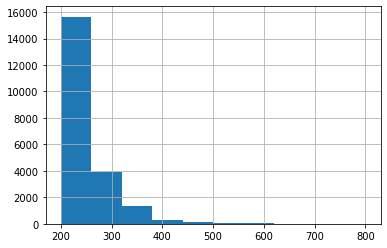

In [85]:
# максимальную мощность выберем 600 л.с.
df['power'].hist(range=(200, 800))

In [86]:
# сделаем мощность ниже в 10 раз
def devide_by_ten(val):
    if val < 600:
        return val
    return val / 10

In [87]:
df['power'] = df['power'].apply(devide_by_ten)
df['power'] = df['power'].apply(devide_by_ten)
df['power'] = df['power'].astype('int')

In [88]:
#df['power'].describe()

In [89]:
brief_df(df)

Размер: (297916, 11)
Дубликаты: 25 ---> 0.0084 %
Проверка на отсутсвующие значениия


,index,values_na,values_not_na,complete_ratio,cardinality
0,price,0,297916,100.0,3657
1,vehicle_type,0,297916,100.0,8
2,registration_year,0,297916,100.0,78
3,gearbox,0,297916,100.0,3
4,power,0,297916,100.0,443
5,model,0,297916,100.0,250
6,kilometer,0,297916,100.0,13
7,registration_month,0,297916,100.0,13
8,fuel_type,0,297916,100.0,6
9,brand,0,297916,100.0,40


Первые пять строк


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
0,480,other,1993,manual,0,golf,150000,0,petrol,volkswagen,other
2,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,other
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,petrol,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes


**Резюме**:
1. удалили неинформативные столбцы
2. привели к регистру
3. удалили явные дубликаты
4. обработали неявные дубликаты
5. обработали пропуски: сперва прицепы `sonstige_autos`, затем *model*, затем *fuel_type*
6. для оставшихся пропусков поставили заглушку `other`;
7. удалили подозрительные года регистрации

Теперь можно приступать к обучению.

## Обучение моделей

### Подготовка выборки для обучения моделей

In [90]:
# ресет индексов для дальнейших манипуляций
df=df.reset_index(drop=True)

In [91]:
# создадим список категориальных признаков, которые необходимо прокодировать
cat_features_OE = df.select_dtypes(include='object').columns.to_list()
cat_features_OE

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

In [92]:
encoder = OrdinalEncoder()

# обучаем энкодер на списке категориальных признаков 
df_temp = pd.DataFrame(encoder.fit_transform(df[cat_features_OE]),
                            columns=df[cat_features_OE].columns)

In [93]:
df_temp = df_temp.astype('int')
df_temp

,vehicle_type,gearbox,model,fuel_type,brand,repaired
0,3,1,116,5,38,1
1,6,0,117,5,14,1
2,5,1,116,5,38,0
3,5,1,101,5,31,0
4,4,1,11,5,2,2
...,...,...,...,...,...,...
297911,3,1,78,5,22,2
297912,3,2,166,4,33,1
297913,1,0,106,5,32,0
297914,0,1,224,5,38,0


In [94]:
# вернем закодированные признаки обратно в базу
df_ordinal = df.copy()
df_ordinal[cat_features_OE] = df_temp[cat_features_OE]
df_ordinal

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
0,480,3,1993,1,0,116,150000,0,5,38,1
1,9800,6,2004,0,163,117,125000,8,5,14,1
2,1500,5,2001,1,75,116,150000,6,5,38,0
3,3600,5,2008,1,69,101,90000,7,5,31,0
4,650,4,1995,1,102,11,150000,10,5,2,2
...,...,...,...,...,...,...,...,...,...,...,...
297911,0,3,2005,1,0,78,150000,7,5,22,2
297912,2200,3,2005,2,0,166,20000,1,4,33,1
297913,1199,1,2000,0,101,106,125000,3,5,32,0
297914,9200,0,1996,1,102,224,150000,3,5,38,0


In [95]:
# разделим данные на три выборки: обучающую, валидационную и тестовую в соотношении 60/20/20
features_train, features_test, target_train, target_test = \
train_test_split(df_ordinal.drop('price', axis=1), df_ordinal.price, test_size=0.2, random_state=12345)

features_train, features_valid, target_train, target_valid = \
train_test_split(features_train, target_train, test_size=0.25, random_state=12345)

In [96]:
# соотношение выборок по объему
print(f"train = {100*len(features_train)/len(df_ordinal):.2f}%")
print(f"val = {100*len(features_valid)/len(df_ordinal):.2f}%")
print(f"test = {100*len(features_test)/len(df_ordinal):.2f}%")

train = 60.00%
val = 20.00%
test = 20.00%


### Обучение CatBoostRegressor

In [97]:
cat_features = ['vehicle_type', 'registration_year', 'gearbox',
                'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand', 'repaired']

In [98]:
model = CatBoostRegressor(loss_function="RMSE", depth=6, learning_rate=0.4, iterations=50)

In [99]:
%%time

best_model_CBR = None
best_result_CBR = 5000000
best_iterations_CBR = 0
best_depth_CBR = 0
for iterat in tqdm(range(10, 51, 10)):  
    for depth in range (1, 11):
        model = CatBoostRegressor(random_state=12345, loss_function="RMSE", depth=depth, 
                                  learning_rate=0.6, iterations=iterat)
        model.fit(features_train, target_train, cat_features=cat_features, verbose=100)
        predicted_valid = model.predict(features_valid)
        result = mean_squared_error(target_valid, predicted_valid, squared=False)
    if result < best_result_CBR:
        best_model_CBR = model
        best_result_CBR = result
        best_iterations_CBR = iterat
        best_depth_CBR = depth

  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 3718.0961473	total: 74.1ms	remaining: 667ms
9:	learn: 2772.0974110	total: 423ms	remaining: 0us
0:	learn: 3600.9858200	total: 99.3ms	remaining: 893ms
9:	learn: 2423.2501513	total: 558ms	remaining: 0us
0:	learn: 3487.6099800	total: 105ms	remaining: 944ms
9:	learn: 2304.5429302	total: 674ms	remaining: 0us
0:	learn: 3382.0218244	total: 117ms	remaining: 1.05s
9:	learn: 2210.9373367	total: 801ms	remaining: 0us
0:	learn: 3297.1166575	total: 151ms	remaining: 1.36s
9:	learn: 2161.2024322	total: 1.02s	remaining: 0us
0:	learn: 3248.1179892	total: 231ms	remaining: 2.08s
9:	learn: 2130.3173575	total: 1.31s	remaining: 0us
0:	learn: 3202.7149468	total: 163ms	remaining: 1.47s
9:	learn: 2091.3727528	total: 1.26s	remaining: 0us
0:	learn: 3192.8975721	total: 203ms	remaining: 1.83s
9:	learn: 2032.0345251	total: 1.46s	remaining: 0us
0:	learn: 3185.5282809	total: 206ms	remaining: 1.86s
9:	learn: 1993.4033287	total: 1.63s	remaining: 0us
0:	learn: 3185.3949350	total: 218ms	remaining: 1.96s
9:	learn:

 20%|██        | 1/5 [00:24<01:36, 24.19s/it]

0:	learn: 3718.0961473	total: 61.4ms	remaining: 1.17s
19:	learn: 2582.9047549	total: 714ms	remaining: 0us
0:	learn: 3600.9858200	total: 80.4ms	remaining: 1.53s
19:	learn: 2286.1448457	total: 921ms	remaining: 0us
0:	learn: 3487.6099800	total: 113ms	remaining: 2.15s
19:	learn: 2193.7249739	total: 1.38s	remaining: 0us
0:	learn: 3382.0218244	total: 147ms	remaining: 2.8s
19:	learn: 2123.2240967	total: 1.77s	remaining: 0us
0:	learn: 3297.1166575	total: 131ms	remaining: 2.48s
19:	learn: 2073.0076107	total: 1.94s	remaining: 0us
0:	learn: 3248.1179892	total: 145ms	remaining: 2.76s
19:	learn: 2032.7892861	total: 2.12s	remaining: 0us
0:	learn: 3202.7149468	total: 197ms	remaining: 3.74s
19:	learn: 1992.7229956	total: 2.49s	remaining: 0us
0:	learn: 3192.8975721	total: 187ms	remaining: 3.55s
19:	learn: 1950.3894405	total: 2.72s	remaining: 0us
0:	learn: 3185.5282809	total: 203ms	remaining: 3.85s
19:	learn: 1889.5981677	total: 3.37s	remaining: 0us
0:	learn: 3185.3949350	total: 201ms	remaining: 3.82s
1

 40%|████      | 2/5 [00:58<01:30, 30.00s/it]

0:	learn: 3718.0961473	total: 58.1ms	remaining: 1.69s
29:	learn: 2526.2793881	total: 961ms	remaining: 0us
0:	learn: 3600.9858200	total: 113ms	remaining: 3.27s
29:	learn: 2223.0223604	total: 1.55s	remaining: 0us
0:	learn: 3487.6099800	total: 101ms	remaining: 2.92s
29:	learn: 2145.1077017	total: 1.82s	remaining: 0us
0:	learn: 3382.0218244	total: 116ms	remaining: 3.36s
29:	learn: 2078.9364907	total: 2.31s	remaining: 0us
0:	learn: 3297.1166575	total: 128ms	remaining: 3.7s
29:	learn: 2026.1009734	total: 2.84s	remaining: 0us
0:	learn: 3248.1179892	total: 136ms	remaining: 3.93s
29:	learn: 1978.2985832	total: 3.06s	remaining: 0us
0:	learn: 3202.7149468	total: 179ms	remaining: 5.2s
29:	learn: 1940.9605150	total: 3.83s	remaining: 0us
0:	learn: 3192.8975721	total: 182ms	remaining: 5.27s
29:	learn: 1886.6442628	total: 4.34s	remaining: 0us
0:	learn: 3185.5282809	total: 211ms	remaining: 6.12s
29:	learn: 1826.3014876	total: 5.13s	remaining: 0us
0:	learn: 3185.3949350	total: 203ms	remaining: 5.9s
29:	

 60%|██████    | 3/5 [01:41<01:12, 36.10s/it]

0:	learn: 3718.0961473	total: 100ms	remaining: 3.92s
39:	learn: 2502.9677609	total: 1.33s	remaining: 0us
0:	learn: 3600.9858200	total: 75.8ms	remaining: 2.96s
39:	learn: 2188.0765767	total: 1.84s	remaining: 0us
0:	learn: 3487.6099800	total: 115ms	remaining: 4.48s
39:	learn: 2115.7382819	total: 2.52s	remaining: 0us
0:	learn: 3382.0218244	total: 147ms	remaining: 5.73s
39:	learn: 2045.6635858	total: 3.06s	remaining: 0us
0:	learn: 3297.1166575	total: 132ms	remaining: 5.16s
39:	learn: 1994.5429866	total: 3.63s	remaining: 0us
0:	learn: 3248.1179892	total: 138ms	remaining: 5.39s
39:	learn: 1946.8023020	total: 4.29s	remaining: 0us
0:	learn: 3202.7149468	total: 162ms	remaining: 6.32s
39:	learn: 1912.2854335	total: 4.9s	remaining: 0us
0:	learn: 3192.8975721	total: 175ms	remaining: 6.83s
39:	learn: 1852.0401401	total: 5.29s	remaining: 0us
0:	learn: 3185.5282809	total: 198ms	remaining: 7.72s
39:	learn: 1783.9331249	total: 6.49s	remaining: 0us
0:	learn: 3185.3949350	total: 208ms	remaining: 8.13s
39

 80%|████████  | 4/5 [02:35<00:43, 43.18s/it]

0:	learn: 3718.0961473	total: 53.5ms	remaining: 2.62s
49:	learn: 2489.0672794	total: 1.52s	remaining: 0us
0:	learn: 3600.9858200	total: 79.3ms	remaining: 3.89s
49:	learn: 2162.6034893	total: 2.27s	remaining: 0us
0:	learn: 3487.6099800	total: 98.2ms	remaining: 4.81s
49:	learn: 2088.6466376	total: 2.84s	remaining: 0us
0:	learn: 3382.0218244	total: 106ms	remaining: 5.17s
49:	learn: 2024.1995295	total: 3.5s	remaining: 0us
0:	learn: 3297.1166575	total: 124ms	remaining: 6.07s
49:	learn: 1970.6956210	total: 4.5s	remaining: 0us
0:	learn: 3248.1179892	total: 137ms	remaining: 6.72s
49:	learn: 1925.0786905	total: 5.12s	remaining: 0us
0:	learn: 3202.7149468	total: 154ms	remaining: 7.56s
49:	learn: 1882.6861564	total: 5.74s	remaining: 0us
0:	learn: 3192.8975721	total: 180ms	remaining: 8.84s
49:	learn: 1821.8958219	total: 6.86s	remaining: 0us
0:	learn: 3185.5282809	total: 223ms	remaining: 10.9s
49:	learn: 1755.6014755	total: 8.1s	remaining: 0us
0:	learn: 3185.3949350	total: 215ms	remaining: 10.6s
49

100%|██████████| 5/5 [03:36<00:00, 43.34s/it]

CPU times: user 3min 4s, sys: 2.29 s, total: 3min 6s
Wall time: 3min 36s


In [100]:
print(f"CatBoostRegressor rmse: {best_result_CBR}")
print(f"best_iterations: {best_iterations_CBR}")
print(f"best_depth: {best_depth_CBR}")

CatBoostRegressor rmse: 1841.6008318140584
best_iterations: 50
best_depth: 10


### LGBMRegressor

In [102]:
%%time


# воспользуемся гиперпараметрами CatBoost
model_LGBM = LGBMRegressor(random_state=12345, max_depth=10, 
                          learning_rate=0.6, n_estimators=50)
model_LGBM.fit(features_train, target_train)
predicted_valid = model_LGBM.predict(features_valid)
print(mean_squared_error(target_valid, predicted_valid, squared=False))

1769.846280438011
CPU times: user 2min 57s, sys: 2.27 s, total: 2min 59s
Wall time: 3min


### RandomForestRegressor

In [103]:
# подберем гиперпараметры для RandomForestRegressor


best_model_RFR = None
best_result_RFR = 5000000
best_est_RFR = 0
best_depth_RFR = 0
for est in tqdm(range(10, 101, 10)):
    for depth in range (5, 16):
        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        result = mean_squared_error(target_valid, predicted_valid, squared=False)
    if result < best_result_RFR:
        best_model_RFR = model
        best_result_RFR = result
        best_est_RFR = est
        best_depth_RFR = depth

100%|██████████| 10/10 [27:49<00:00, 166.97s/it]


In [104]:
print(f"RandomForestRegressor rmse: {best_result_RFR}")
print(f"best_iterations: {best_est_RFR}")
print(f"best_depth: {best_depth_RFR}")

RandomForestRegressor rmse: 1788.0072500260624
best_iterations: 100
best_depth: 15


## Анализ моделей

Проанализируем время предсказания и обучения для трех моделей с лучшим RMSE

### CatBoostRegressor

In [105]:
%%time

model_CBR = CatBoostRegressor(random_state=12345, loss_function="RMSE", depth=10, 
                          learning_rate=0.6, iterations=50)
model_CBR.fit(features_train, target_train, cat_features=cat_features, verbose=100)

0:	learn: 3185.3949350	total: 199ms	remaining: 9.73s
49:	learn: 1684.6667004	total: 7.9s	remaining: 0us
CPU times: user 8.4 s, sys: 60.1 ms, total: 8.46 s
Wall time: 9.27 s


In [106]:
%%time

predicted_valid = model_CBR.predict(features_valid)
result = mean_squared_error(target_valid, predicted_valid, squared=False)
print(f"CatBoostRegressor rmse: {result:.3f}")

CatBoostRegressor rmse: 1841.601
CPU times: user 170 ms, sys: 8 µs, total: 170 ms
Wall time: 172 ms


### LGBMRegressor

In [108]:
%%time

model_LGBM = LGBMRegressor(random_state=12345, max_depth=10, 
                          learning_rate=0.6, n_estimators=50)
model_LGBM.fit(features_train, target_train)

CPU times: user 1min 29s, sys: 1.1 s, total: 1min 30s
Wall time: 1min 30s


LGBMRegressor(learning_rate=0.6, max_depth=10, n_estimators=50,
              random_state=12345)

In [113]:
%%time

predicted_valid = model_LGBM.predict(features_valid)
result = mean_squared_error(target_valid, predicted_valid, squared=False)
print(f"LGBMRegressor rmse: {result:.3f}")

LGBMRegressor rmse: 1784.820
CPU times: user 222 ms, sys: 3.89 ms, total: 226 ms
Wall time: 162 ms


### RandomForestRegressor

In [110]:
%%time

model_RFR = RandomForestRegressor(random_state=12345, n_estimators=100, max_depth=15)
model_RFR.fit(features_train, target_train)

CPU times: user 37.1 s, sys: 24 ms, total: 37.2 s
Wall time: 37.2 s


RandomForestRegressor(max_depth=15, random_state=12345)

In [112]:
%%time

predicted_valid = model_RFR.predict(features_valid)
result = mean_squared_error(target_valid, predicted_valid, squared=False)
print(f"RandomForestRegressor rmse: {result:.3f}")

RandomForestRegressor rmse: 1788.007
CPU times: user 1.07 s, sys: 13 µs, total: 1.07 s
Wall time: 1.07 s


### Результат

In [118]:
# поместим полученный результаты в таблицу
# время в таблице – Wall time
compare = {
    'model':['CatBoostRegressor', 'LGBMRegressor', 'RandomForestRegressor'],
    'RMSE':[1841.601,1784.820,1788.007],
    'learning time, s':[9.27,90,37.2],
    'prediction time, ms':[172,162,1070]}

In [119]:
pd.DataFrame(compare)

,model,RMSE,"learning time, s","prediction time, ms"
0,CatBoostRegressor,1841.601,9.27,172
1,LGBMRegressor,1784.820,90.00,162
2,RandomForestRegressor,1788.007,37.20,1070


**Вывод:**
CatBoostRegressor показал лучшее время обучения.

LGBMRegressor показал самое высокое качество предсказания и самое медленное обучение.

у RandomForestRegressor средние показатели.

Т.к. порог качества в 2500 преодолели все модели, ориентироваться будем по времени, а у **CatBoostRegressor** эти показатели наилучшие, поэтому для теста выберем её.

## Тестирование модели

In [121]:
predicted_test = model_CBR.predict(features_test)
result = mean_squared_error(target_test, predicted_test, squared=False)
print(f"CatBoostRegressor rmse: {result:.3f}")

CatBoostRegressor rmse: 1833.002


Тут же проверим модель на адекватность.

In [125]:
# предсказывать будем медиану

dummy_regr = DummyRegressor(strategy='median')
dummy_regr.fit(features_train, target_train)
DummyRegressor()
predicted_test = dummy_regr.predict(features_test)

result = mean_squared_error(target_test, predicted_test, squared=False)
print(f"DummyRegressor rmse: {result:.3f}")

DummyRegressor rmse: 4848.259


## Вывод

В ходе проекта выполнены следующие шаги:
* Загрузка и изучение данных
* Предобработка данных
* Подготовка выборки для обучения моделей.
* Обучение моделей
* Анализ моделей

Критерии, которые важны заказчику:
* качество предсказания
* время обучения модели
* время предсказания модели

Этим критериям отвечают все модели, но у **CatBoostRegressor** с гиперпараметрами: `depth=10, learning_rate=0.6, iterations=50` лучшие показатели: `RMSE=1841.60, learning time 9.27s, prediction time 172ms`.

После чего модель прошла тест и проверку на адекватность.